# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 3

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

Finished!


In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from stepbystep.v0 import StepByStep

# A Simple Classification Problem

## Data Generation

In [3]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [4]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

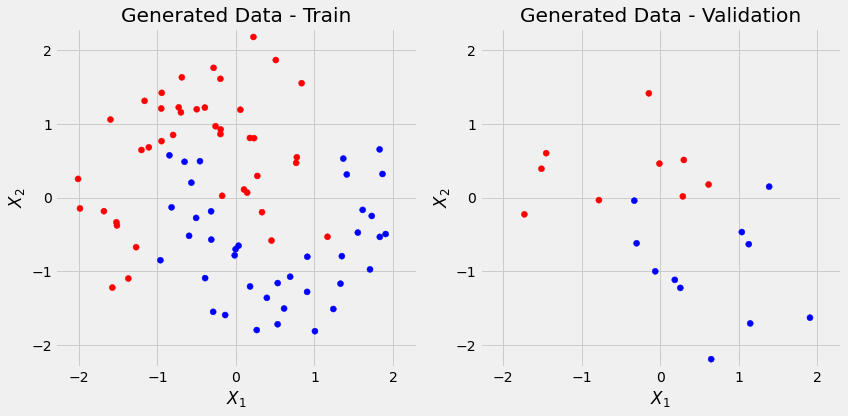

In [5]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

In [7]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()#torch.tensor(X_val)会有dtype
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [10]:
torch.tensor(X_val)

tensor([[-0.3318, -0.0405],
        [-0.3028, -0.6182],
        [-1.5143,  0.3922],
        [-0.0116,  0.4619],
        [-1.7317, -0.2256],
        [ 1.3856,  0.1497],
        [ 0.6143,  0.1784],
        [ 0.6474, -2.1897],
        [ 1.9053, -1.6269],
        [-0.7827, -0.0331],
        [-0.0652, -0.9987],
        [ 0.2862,  0.0172],
        [ 1.1442, -1.7050],
        [-1.4543,  0.6032],
        [ 0.1836, -1.1142],
        [ 0.2545, -1.2234],
        [-0.1467,  1.4146],
        [ 1.1256, -0.6308],
        [ 1.0372, -0.4664],
        [ 0.2985,  0.5114]], dtype=torch.float64)

# A Simple Classification Problem
It is time to handle a different class of problems: classification problems (pun intended). In a classification problem, we're trying to predict which class a data point belongs to.

Let's say we have two classes of points: they are either red or blue. These are the labels ( $y$ ) of the points. Sure enough, we need to assign numeric values to them. We could assign zero to red and one to blue. The class associated with zero is the negative class, while one corresponds to the positive class.
In a nutshell, for binary classification, we have:

$$
\begin{array}{lll}
\text { Color } & \text { Value } & \text { Class } \\
\hline \text { Red } & 0 & \text { Negative } \\
\hline \text { Blue } & 1 & \text { Positive }
\end{array}
$$




## Model

Given a classification problem, one of the more straightforward models is the logistic regression. But, instead of simply presenting it and using it right away, I am going to build up to it. The rationale behind this approach is twofold: first, it will make clear why this algorithm is called logistic regression if it is used for classification; second, you'll get a clear understanding of what a logit is.

Well, since it is called logistic regression, I would say that linear regression is a good starting point for us to build up to it. How would a linear regression model with two features look like?



$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

### Logits


#### Different
(2) "Does it mean a logit is the same as linear regression?"

Not quite... there is one fundamental difference between them: there is no error term (epsilon) in Equation 3.3.

(3) "If there is no error term, where does the **uncertainty** come from?"

I am glad you asked :-) That's the role of the probability: instead of assigning a data point to a discrete label (zero or one), we'll compute the probability of a data point belonging to the positive class.

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

### Probabilities


If a data point has a logit equals zero, it is exactly at the decision boundary since it is neither positive nor negative. For the sake of completeness, we assigned it to the positive class, but this assignment has maximum uncertainty, right? So, the corresponding probability needs to be $0.5(50 \%)$, since it could go either way...

Following this reasoning, we would like to have large positive logit values assigned to higher probabilities (of being in the positive class) and large negative logit values assigned to lower probabilities (of being in the positive class).

For really large positive and negative logit values (z), we would like to have:

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

### Odds Ratio


This is a colloquial expression meaning something very unlikely has happened. But odds do not have to refer to an unlikely event or a slim chance. The odds of getting heads in a (fair) coin flip are 1 to 1 since there is a $50 \%$ chance of success and a $50 \%$ chance of failure.

Let's imagine we are betting on the winner of the World Cup's final. There are two countries: $\mathbf{A}$ and B. Country $\mathbf{A}$ is the favorite: it has a $75 \%$ chance of winning. So, Country $B$ has only a $25 \%$ chance of winning. If you bet on Country $A$, your chances of winning, that is, your odds (in favor) are 3 to 1 (75 to 25). If you decide to test your luck and bet on Country B, your chances of winning, that is, your odds (in favor) are 1 to 3 ( 25 to 75 ), or $0.33$ to 1 .

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In [11]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [12]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

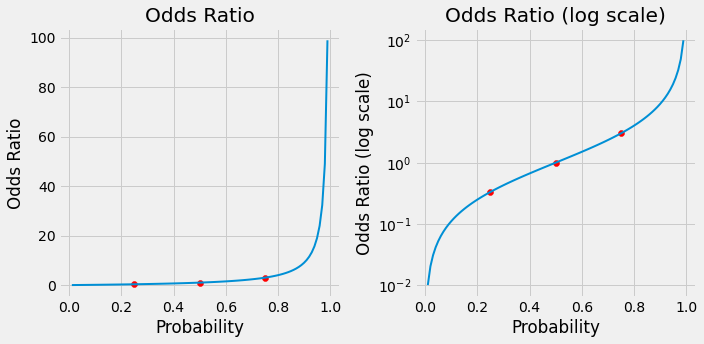

In [13]:
fig = figure2(p)

Clearly, the odds ratios (left plot) are not symmetrical. But, in a log scale (right plot), they are. This serves us very well since we're looking for a symmetrical function that maps logit values into probabilities.


If the function weren't symmetrical, different choices for the positive class would produce models that were not equivalent. But, using a symmetrical function, we could train two equivalent models using the same dataset, just flipping the classes:

- Blue Model (the positive class $(y=1)$ corresponds to blue points)
- Data Point #1: $\mathrm{P}(\mathrm{y}=1)=\mathrm{P}($ blue $)=.83$ (which is the same as $\mathrm{P}(\mathrm{red})=.17)$

Log Odds Ratio
By taking the logarithm of the odds ratio, the function is not only symmetrical, but it also maps probabilities into real numbers, instead of only the positive ones:
$$
\log \text { odds ratio }(p)=\log \left(\frac{p}{1-p}\right)
$$
Equation 3.6 - Log odds ratio

### Log Odds Ratio

- for symmatry

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

In [14]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

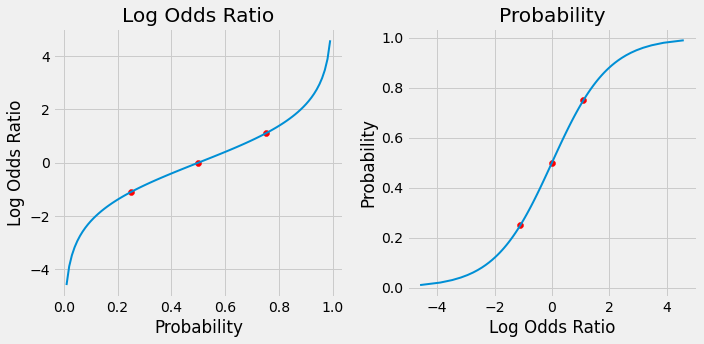

In [15]:
fig = figure3(p)

### From Logits to Probabilities

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

### Sigmoid

Sigmoid, nonlinearities, and activation functions
The sigmoid function is nonlinear. It can be used to map logits into probabilities, as we've just figured out. But this is not its only purpose!

Nonlinear functions play a fundamental role in neural networks. We know these nonlinearities by their usual name: activation functions.

The sigmoid is the "biologically-inspired" and the first activation function to be used back in the old days. It was followed by the hyperbolic-tangent (TanH) and, more recently, by the Rectified Linear Unit (ReLU) and a whole family of functions it spawned.

Moreover, there would be no neural networks without a nonlinear function. Have you ever wondered what would happen to a neural network, no matter how many layers deep, if all its activation functions were removed?

I will get back to this topic in the next chapter, but I will spoil the answer already: the network would be equivalent to linear regression. True story!

In [17]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

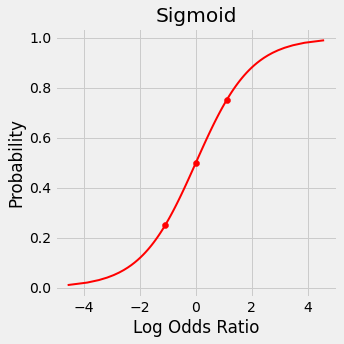

In [18]:
fig = figure4(p)

### Logistic Regression

Given two features, $x_{1}$ and $x_{2}$, the model will fit a linear regression such that its outputs are logits $(z)$, which are converted into probabilities using a sigmoid function.

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/logistic_model.png?raw=1)

In [19]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear',nn.Linear(2,1))
model1.add_module('sigmoid',nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


In [ ]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


### A Note on Notation


So far, we've handled either one feature (up to Chapter 2) or two features (this chapter). It allowed us to spell equations out, listing all terms.

But the number of features will soon increase fast when we tackle images as inputs. So we need to agree on notation for vectorized features. Actually, l've already used it in Figure $3.5$ above.
The vectorized representations of the weights $(W)$ and features $(X)$ are:



$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

## Loss

We already have a model, and now we need to define an appropriate loss for it. A binary classification problem calls for the binary cross-entropy (BCE) loss, sometimes known as log loss.

**The BCE loss requires the predicted probabilities, as returned by the sigmoid function, and the true labels $(y)$ for its computation. For each data point $\boldsymbol{i}$ in the training set, it starts by computing the error corresponding to the point's true class.**

If the data point belongs to the positive class $(y=1)$, we would like our model to predict a probability close to one, right? A perfect one would result in the logarithm of one, which is zero. It makes sense; a perfect prediction means zero loss. It goes like this:

$$
P\left(y_{i}=0\right)=1-P\left(y_{i}=1\right)
$$


And thus, the error associated with a data point belonging to the negative class goes like this:
$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

What if the data point belongs to the negative class $(y=0)$ ? Then we cannot simply use the predicted probability. Why not? Because the model outputs the probability of a point belonging to the positive, not the negative, class. Luckily, the latter can be easily computed:


$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

Once all errors are computed, they are aggregated into a loss value. For the binary-cross entropy loss, we simply take the average of the errors and invert its sign.

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

In [21]:
dummy_labels = torch.tensor([1.0,0.0]) #return a bool list
dummy_predictions = torch.tensor([.9,.2])



In [24]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

In [25]:
summation = torch.sum(
     dummy_labels * torch.log(dummy_predictions) + (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)

loss = -summation / n_total
loss

tensor(0.1643)

In [ ]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss

In [26]:
loss_fn = nn.BCELoss(reduction='mean')

loss_fn

BCELoss()

In [27]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


### BCEWithLogitsLoss

The former loss function took probabilities as an argument (together with the labels, obviously). This loss function takes logits as an argument, instead of probabilities.

In [28]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

In [32]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [30]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

### Imbalanced Dataset


Clearly, this is an imbalanced dataset. There are three times more data points in the negative class than in the positive one. Now, let's turn to the pos_weight argument of BCEWithLogitsLoss. To compensate for the imbalance, one can set the weight equals the ratio of negative to positive examples:

In [33]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

$$
\Large \text{pos_weight} = \frac{\text{# points in negative class}}{\text{# points in positive class}}
$$

In [34]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

In [ ]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weightQ

tensor([3.])

In [36]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

In [37]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

$$
\Large \text{weighted average} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos_weight} N_{\text{pos}}+N_{\text{neg}}}
$$

$$
\Large \text{BCEWithLogitsLoss} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}}+N_{\text{neg}}}
$$

In [ ]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In [38]:
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2,1))

optimizer = optim.SGD(model.parameters(),lr=lr)

loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [39]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

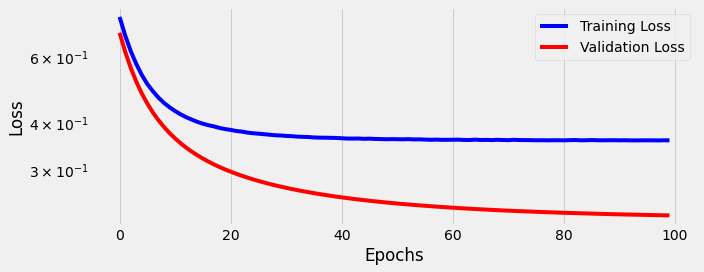

In [40]:
fig = sbs.plot_losses()

In [41]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]])), ('linear.bias', tensor([-0.0591]))])


$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

#### Making Predictions (Logits)

In [42]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.9444451 ],
       [ 3.6933177 ],
       [-1.2334073 ]], dtype=float32)

#### Making Predictions (Probabilities)

In [43]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892 ],
       [0.9500003 ],
       [0.9757152 ],
       [0.22558564]], dtype=float32)

#### Making Predictions (Classes)

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

In [44]:
classes = (predictions >= 0).astype(np.int)
classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([[1],
       [1],
       [1],
       [0]])

## Decision Boundary

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

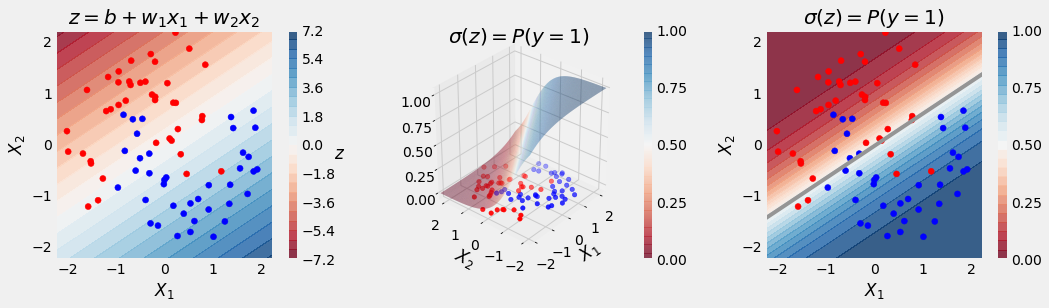

In [45]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

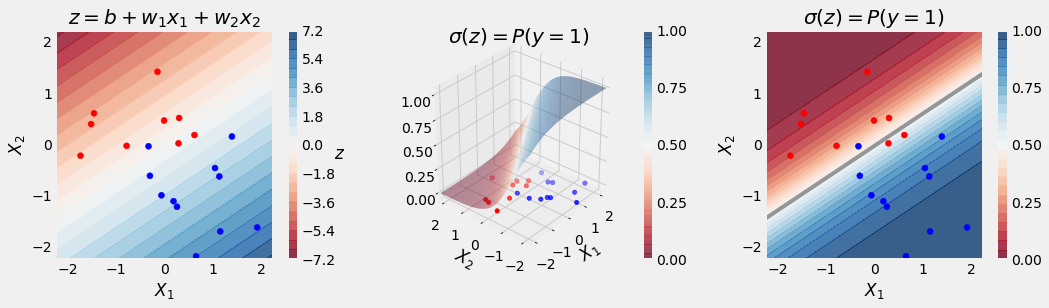

In [ ]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

### Are my data points separable?

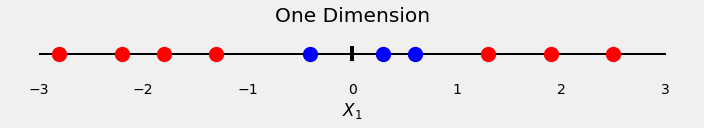

In [46]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

$$
\Large X_2 = f(X_1)= X_1^2
$$

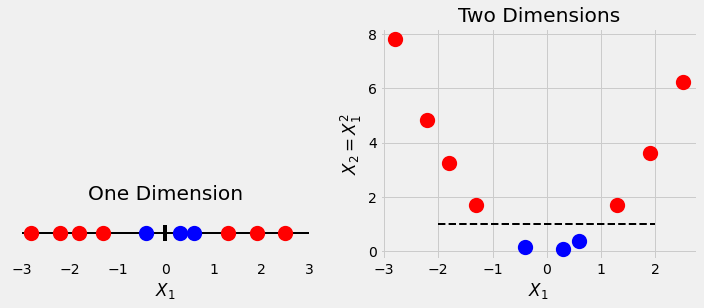

In [47]:
fig = two_dimensions(x, y)

The more dimensions, the more separable the points are.
It is beyond the scope of this book to explain why this trick works. The important thing is to understand the general idea here: as the number of dimensions increases, there is more and more empty space. If the data points are farther apart, it is likely easier to separate them. In two dimensions, the decision boundary is a line. In three dimensions, it is a plane. In four dimensions and more, it is a hyper-plane (fancier wording for a plane you can't draw).

Have you heard of the kernel trick for Support Vector Machines (SVMs)? That's pretty much what it does! The kernel is nothing else but the function we used to create additional dimensions. The square function we used is a polynomial, so we used a polynomial kernel.


- **increase the dimensionality**
Excellent question! It turns out; neural networks may also increase the dimensionality. That's what happens if you add a hidden layer with more units than the number of features. For instance:

In [48]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

## Classification Threshold

### Why? 

In [49]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

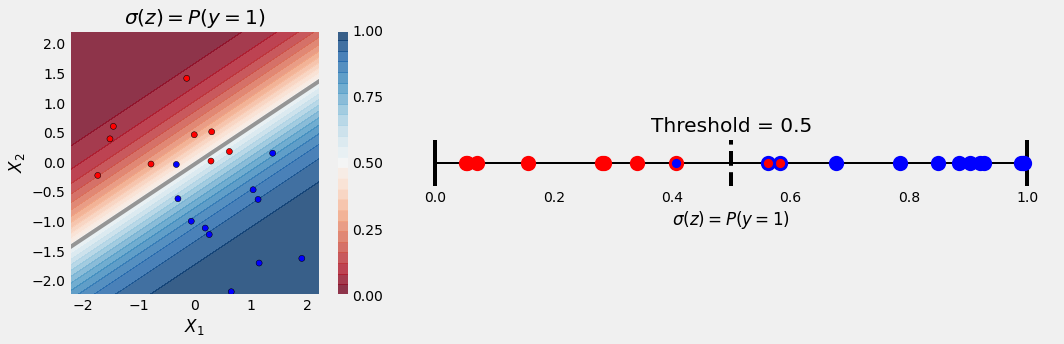

In [50]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

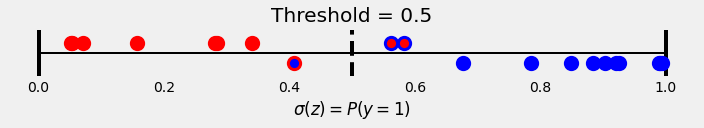

In [51]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

### Confusion Matrix

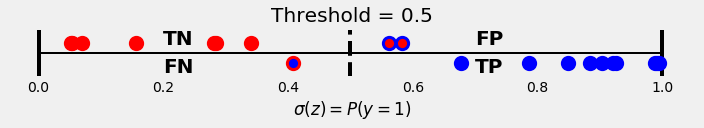

In [ ]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [53]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

#### True and False Positives and Negatives

In [ ]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

### Metrics

### True and False Positive Rates

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [ ]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [ ]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

### Precision and Recall

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [ ]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [ ]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

### Accuracy

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

## Trade-offs and Curves

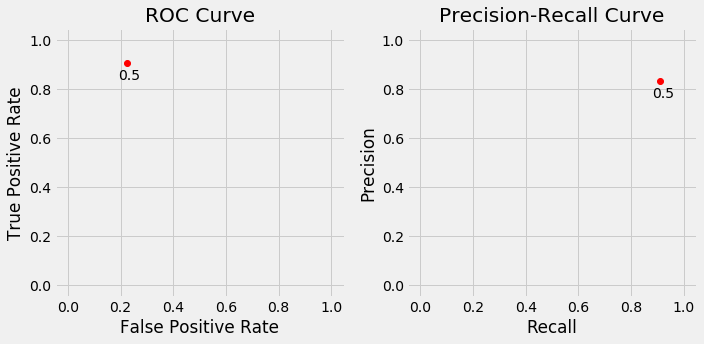

In [ ]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

### Low Threshold

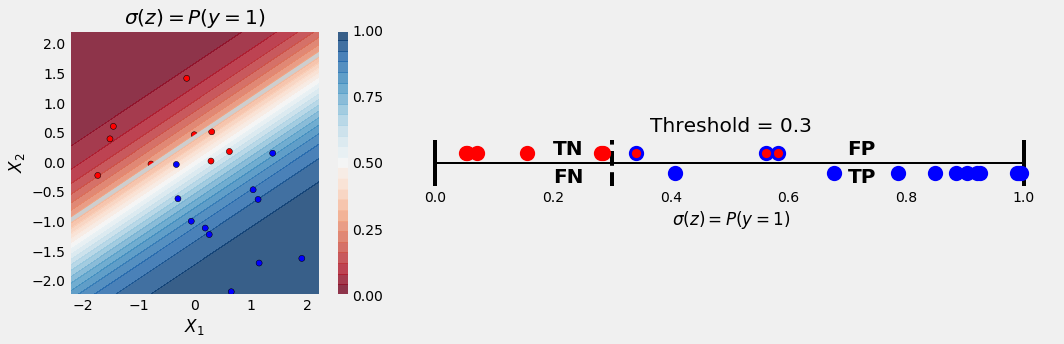

In [ ]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

In [ ]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

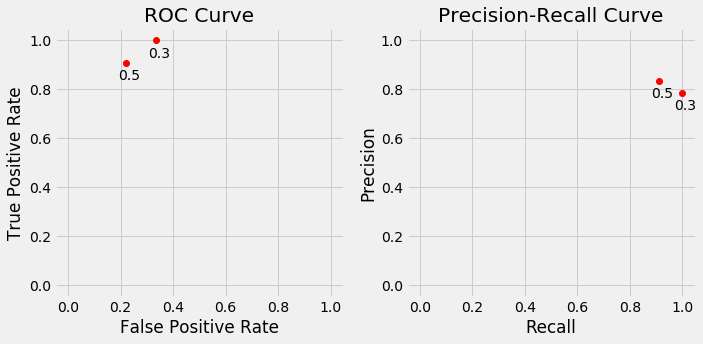

In [ ]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

### High Threshold

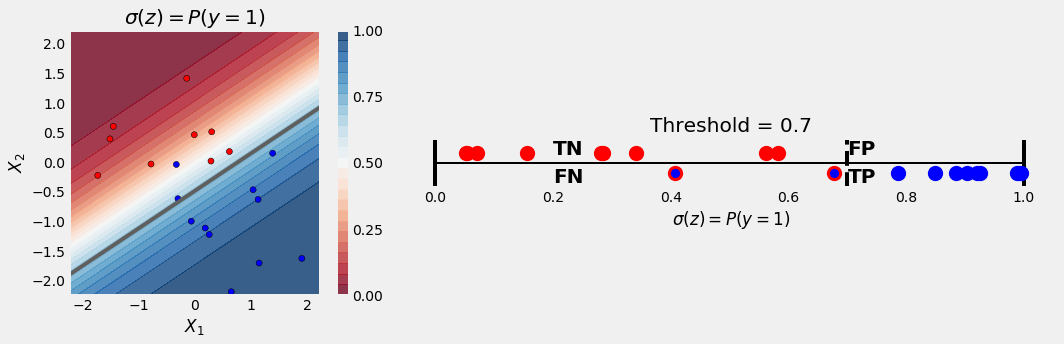

In [ ]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

In [ ]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

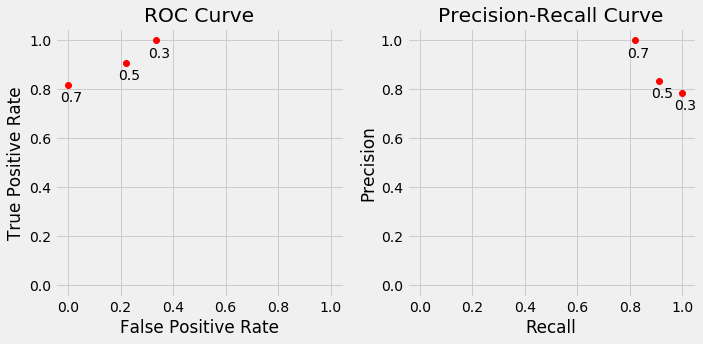

In [ ]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

### ROC and PR Curves

In [ ]:
threshs = np.linspace(0.,1,11)

/home/dvgodoy/projects/PyTorchStepByStep/plots/chapter3.py:49: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


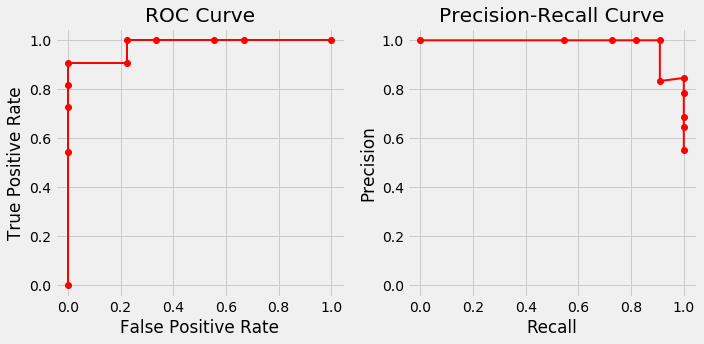

In [ ]:
fig = figure17(y_val, probabilities_val, threshs)

In [ ]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

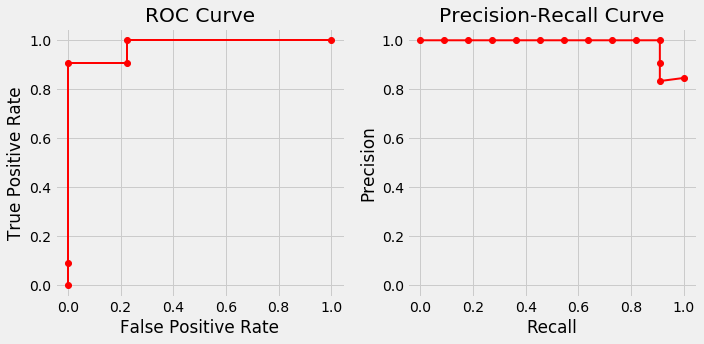

In [ ]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

### The Precision Quirk

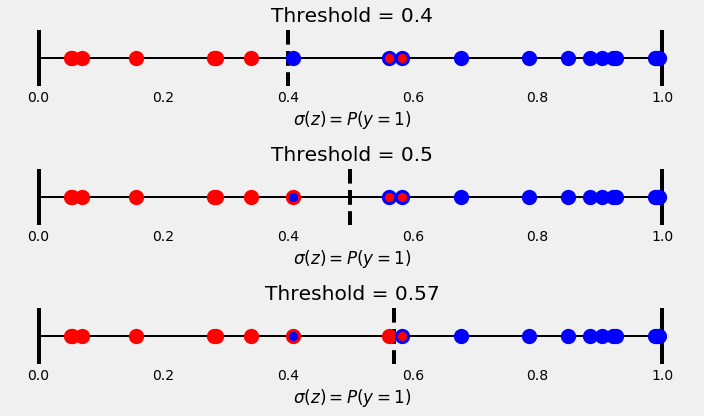

In [ ]:
fig = figure19(y_val, probabilities_val)

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

### Best and Worst Curves

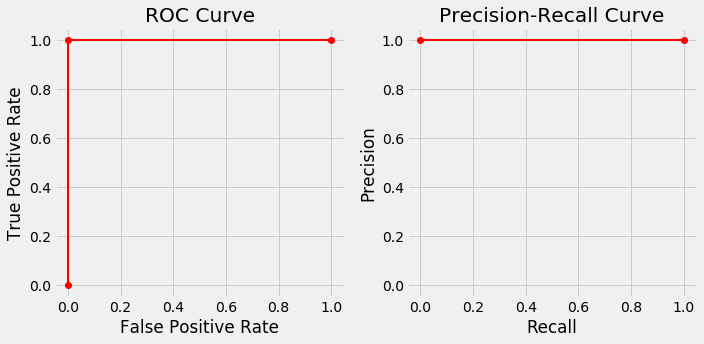

In [ ]:
# Best
fig = figure20(y_val)

In [ ]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [ ]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

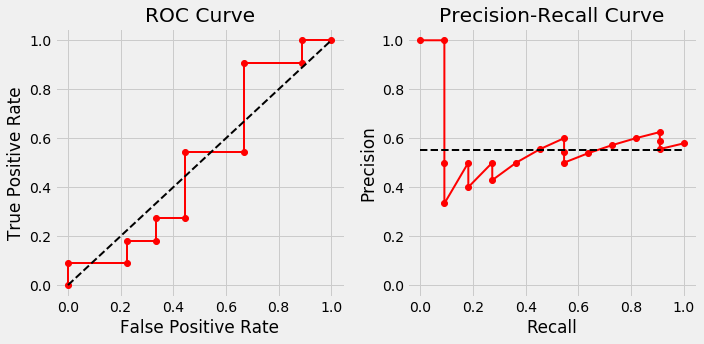

In [ ]:
# Worst
fig = figure21(y_val, random_probs)

### Comparing Models

In [ ]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [ ]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


## Putting It All Together

In [ ]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [ ]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [ ]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1822, -1.8684]], device='cuda:0')), ('linear.bias', tensor([-0.0587], device='cuda:0'))])


In [ ]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])